In [1]:
import pandas_gbq

In [2]:
q='''
with orders as (select analytical_customer_id, global_entity_id, count(analytical_customer_id) as orders_count from `fulfillment-dwh-production.curated_data_shared_coredata_business.orders` where partition_date_local between "2023-08-28" and "2023-08-31" and global_entity_id="FP_TH"
group by analytical_customer_id, global_entity_id),
scores as (select r.analytical_customer_id, case when o.analytical_customer_id is null then "0" else "1" end as reordered, r.global_entity_id, CAST((concated_survival_scores[SAFE_OFFSET(1)] * 100 ) AS INTEGER) AS score,
 from `mkt-reorder-prod.mkt_reorder_prod.historical_predictions_reorder-general-all-ALL` r
left join (select distinct analytical_customer_id, global_entity_id from `fulfillment-dwh-production.curated_data_shared_coredata_business.orders` where partition_date_local = "2023-09-01" and global_entity_id="FP_TH") o on r.analytical_customer_id = o.analytical_customer_id and r.global_entity_id = o.global_entity_id
where scoring_date = "2023-09-01" and r.global_entity_id="FP_TH"
)

select * from scores left join orders using(analytical_customer_id, global_entity_id)
'''

In [3]:
df = pandas_gbq.read_gbq(q)

/Users/a.capuano/opt/miniconda3/envs/ml/lib/python3.10/site-packages/google/auth/_default.py:83: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


Downloading: 100%|██████████|


In [4]:
df.head()

,analytical_customer_id,global_entity_id,reordered,score,orders_count
0,-Ao70eiTVU6pKLJCWeAidw,FP_TH,0,60,<NA>
1,-21fPl8RUiGgk9P2edsNmw,FP_TH,0,60,3
2,-SgSKf3dUdCM7kB4-4yXEQ,FP_TH,0,60,3
3,-R3v8M_XXM-GhjwQG-DjXQ,FP_TH,1,60,1
4,-BarGE6aXF6SpR-xHgbWlw,FP_TH,0,60,2


Customers we have prediction for that did not order:

In [6]:
100*len(df[df['reordered']=='0'])/len(df)

95.1547411833185

Past orders vs predicted score

<AxesSubplot:xlabel='orders_count', ylabel='score'>

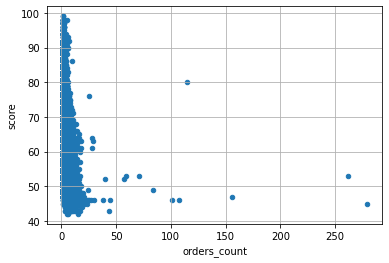

In [11]:
df[df['reordered']=='1'].plot.scatter(y='score', x='orders_count', grid=True)